# Analysis of Simulated Data

<!-- ## Package Installation

Make sure to install auto4dstem from source:

```bash
pip install auto4dstem
``` -->

## Importing Required Packages

In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt

from cmcrameri import cm
from auto4dstem.nn.Train_Function import Train
from auto4dstem.masks.masks import Mask
from auto4dstem.viz.diffraction import display_diffraction_image, display_noisy_diffraction
from auto4dstem.viz.simulated_4DSTEM import VisualizeSimulation
from auto4dstem.viz.viz import (
    PlotStyleClass,
    visual_performance_plot,
)
from m3util.util.IO import download_files_from_txt

## GPU Settings

The notebook is designed to run on a system with a GPU accelerator this code will check is a GPU is available. 

In [2]:
!nvidia-smi

Tue Jun  3 15:19:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.153.02             Driver Version: 570.153.02     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               On  |   00000000:01:00.0 Off |                  Off |
| 30%   31C    P8             16W /  300W |     397MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Selects the GPU device to use. 

In [3]:
# you can change the device number to the one you want to use
device_number = 0

device = torch.device(f"cuda:{device_number}" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device) 
print("Current CUDA device index:", torch.cuda.current_device())

Current CUDA device index: 0


## Visualization Format 

Set the format for standard plotting throughout the notebook

In [4]:
plot_style = PlotStyleClass()
plot_style.apply_global_style()

## Download Data and Pre-Trained Models

In [ ]:
data_path = os.path.abspath('./data/simulated_4dstem/')
file_download = f"{data_path}/simulated_data_urls.txt"

# check where are you from the root path
download_files_from_txt(file_download, data_path)

  0%|          | 0/72 [00:00<?, ?it/s]

  1%|▏         | 1/72 [00:00<00:30,  2.30it/s]

File already exists: 40percent_noisy_simulated_4dstem_pretrained_weights.pkl


  3%|▎         | 2/72 [00:00<00:29,  2.39it/s]

File already exists: 45percent_noisy_simulated_4dstem_pretrained_weights.pkl


  4%|▍         | 3/72 [00:01<00:28,  2.43it/s]

File already exists: 60Percent_pretrained_rotation.npy


  6%|▌         | 4/72 [00:01<00:34,  1.98it/s]

File already exists: analysis_bg50per_1e5counts__strain.h5


  7%|▋         | 5/72 [00:02<00:32,  2.08it/s]

File already exists: 25percent_noisy_simulated_4dstem_pretrained_weights.pkl


  8%|▊         | 6/72 [00:02<00:30,  2.19it/s]

File already exists: 20Percent_pretrained_rotation.npy


 10%|▉         | 7/72 [00:03<00:28,  2.26it/s]

File already exists: Label_shear_xy.npy


 11%|█         | 8/72 [00:03<00:27,  2.31it/s]

File already exists: Label_strain_yy.npy


 12%|█▎        | 9/72 [00:03<00:26,  2.36it/s]

File already exists: 25Percent_pretrained_rotation.npy


 14%|█▍        | 10/72 [00:04<00:25,  2.40it/s]

File already exists: 10percent_noisy_simulated_4dstem_pretrained_weights.pkl


 15%|█▌        | 11/72 [00:04<00:25,  2.43it/s]

File already exists: 30percent_noisy_simulated_4dstem_pretrained_weights.pkl


 17%|█▋        | 12/72 [00:05<00:24,  2.45it/s]

File already exists: analysis_bg40per_1e5counts__strain.h5


 18%|█▊        | 13/72 [00:05<00:24,  2.45it/s]

File already exists: 05percent_noisy_simulated_4dstem_pretrained_weights.pkl


 19%|█▉        | 14/72 [00:05<00:23,  2.44it/s]

File already exists: 70percent_noisy_simulated_4dstem_pretrained_weights.pkl


 21%|██        | 15/72 [00:06<00:23,  2.43it/s]

File already exists: analysis_bg45per_1e5counts__strain.h5


 22%|██▏       | 16/72 [00:06<00:22,  2.44it/s]

File already exists: 00percent_noisy_simulated_4dstem_pretrained_weights.pkl


 24%|██▎       | 17/72 [00:07<00:22,  2.45it/s]

File already exists: 60percent_noisy_simulated_4dstem_pretrained_weights.pkl


 25%|██▌       | 18/72 [00:07<00:21,  2.47it/s]

File already exists: 35percent_noisy_simulated_4dstem_pretrained_weights.pkl


## Learning Crystallographic Rotation

The first step is to learn the course crystallographic rotation of the data. To do this, we apply a ring mask to the data to calculate the loss in the region of interest where there are diffraction spots. This avoids the central region where there is no diffraction spot - and limited information regarding the crystal structure and strain. 



### Construct Circular Mask

We build a ring mask with inner radius 50 and outer radius 85, to only calculate the loss in the region of interest where there are diffraction spots. 

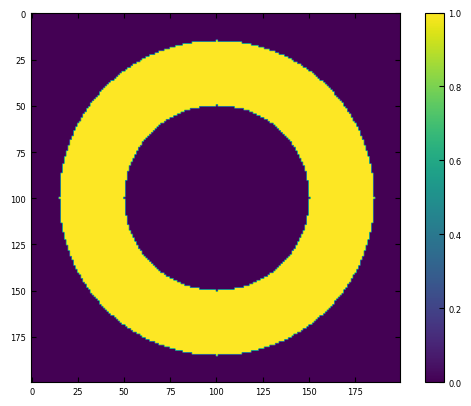

In [7]:
# set mask class
set_mask = Mask()

# generate mask
mask_tensor, mask_list = set_mask.mask_ring(radius_1=50, radius_2=85)

plt.imshow(mask_tensor)
plt.colorbar()
plt.show()

```{figure} 
:name: Circular_Mask

Figure 1: Visualization of the generated mask tensor using a circular mask with inner radius 50 and outer radius 85.
```

## Benchmark Simulated 4DSTEM Dataset

### Set Parameters

Sets the initial Background level (BKG level), Load Data and Pre-Trained Weights

In [8]:
background_intensity = 0
background_string = format(int(background_intensity * 100), "02d")
data_file = os.path.abspath(f"{data_path}/polycrystal_output4D.mat")
rotation_path = f"{data_path}/{background_string}Percent_pretrained_rotation.npy"

## Initialize Training Class

This initializes the training class with the given parameters, and loads the data. 

In [11]:
trainer = Train(
    data_file=data_file,
    device=device,
    coarse_learned_angle_adjustment=0,
    transpose=(1, 0, 3, 2),
    background_weight=background_intensity,
    learned_rotation=rotation_path,
    num_base=1,
    upsample_dimensions=800,
    scale_threshold=0.05,
    shear_threshold=0.1,
    rotation_threshold=0.1,
    translation_threshold=0.15,
    learnable_mask_intensity=0,
    dynamic_mask_to_loss_function=mask_list,
    initial_mask=None,
    interpolate_flag=True,
    reverse_affine_transform_flag=False,
    folder_path=data_path,
)

100%|██████████| 65536/65536 [00:00<00:00, 299402.90it/s]


### Random Diffraction Image

Visualization of a random diffraction image from the dataset.

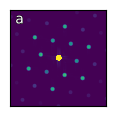

In [22]:
data = trainer.raw_data(index=0)
display_diffraction_image(data, clim=[0, 4e-5])

```{figure} 
:name: Circular_Mask

**Figure 2**: Random diffraction image from 4D-STEM
```

/home/shuyu/4DSTEM/Simulated_4dstem/Extremely_Noisy_4DSTEM_Strain_Mapping_Using_CC_ST_AE_Simulated/figures/Simulated_generated_[0, 0.25, 0.6]_noise.png
/home/shuyu/4DSTEM/Simulated_4dstem/Extremely_Noisy_4DSTEM_Strain_Mapping_Using_CC_ST_AE_Simulated/figures/Simulated_generated_[0, 0.25, 0.6]_noise.svg


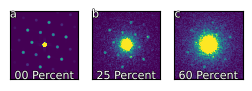

In [11]:
display_noisy_diffraction(data,
    folder_path=os.path.join(folder_path, "figures/"),
    noise_level=[0, 0.25, 0.6],
)

**Figure 2:** Diffraction image with various Poisson distributed noise intensity. a) Raw data. b) 10% noise. c) 25% noise. d) 45% noise. e) 60% noise intensity.